# Assignment 5

# Task 1

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
import os
import copy

# Import data from Google Drive

In [0]:
from google.colab import drive
drive.mount("/content/drive")
data_dir = '/content/drive/My Drive/Colab Notebooks/Assignment 5/Assignment 5 Dataset'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform=val_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


# Display a batch from test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


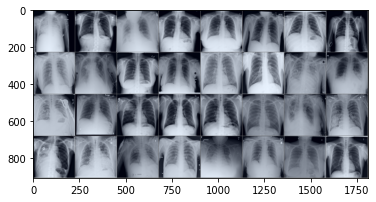

infected normal infected normal normal normal normal normal normal infected normal normal normal normal infected infected infected normal infected normal normal normal infected infected infected infected infected normal infected normal normal normal


In [0]:
# functions to show an image
def imshow(img):
    img = img * 0.22 + 0.45     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

# Load pre-trained VGG16 model and replace the FC layers

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[0].in_features

fc = nn.Sequential(
            nn.Linear(num_features, 220), # roll_no = 12, neurons = 120 + 100
            nn.ReLU(True),
            nn.Linear(220, 2)
        )
vgg16.classifier = fc
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Freeze all Convolution Layers

In [0]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Train the VGG16 model on our dataset 

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

val_loss = list()
val_acc = list()
train_loss = list()
train_acc = list()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        #compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Acc: {}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item(), 100 * correct / total))
    
    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    val_loss.append(running_loss)
    val_acc.append(100 * correct / total)

print('Finished Training')
torch.save(vgg16.state_dict(), F'/content/drive/My Drive/Colab Notebooks/Assignment 5/vgg16_FC_Only.pth')

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.080653 Acc: 89.74166666666666: : 375it [11:11,  1.79s/it]
Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.195910 Acc: 93.1: : 375it [11:03,  1.77s/it]
Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.179928 Acc: 93.925: : 375it [10:52,  1.74s/it]
Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.108345 Acc: 94.10833333333333: : 375it [10:53,  1.74s/it]
Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.134502 Acc: 94.625: : 375it [10:50,  1.73s/it]
Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.270263 Acc: 94.64166666666667: : 375it [10:49,  1.73s/it]
Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.236006 Acc: 95.2: : 375it [10:59,  1.76s/it]
Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.154629 Acc: 95.30833333333334: : 375it [10:49,  1.73s/it]
Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.025489 Acc: 95.61666666666666: : 375it [10:44,  1.72s/it]
Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.160104 Acc: 95.73333333333333: : 375it [10:54,  1.74s/it]


Finished Training


# Plot Accuracy and Loss curves

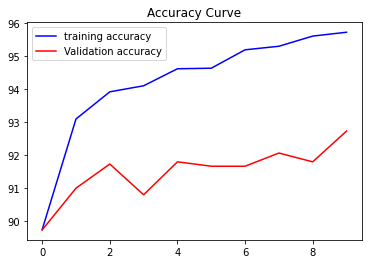

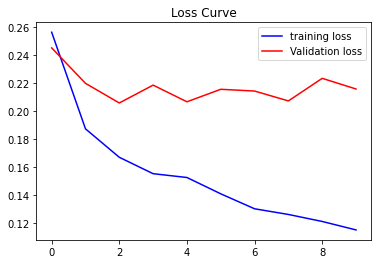

In [0]:
#accuracy curve
plt.subplots()
plt.plot(train_acc, 'b', label = 'training accuracy')
plt.plot(val_acc, 'r', label = 'Validation accuracy')
plt.title("Accuracy Curve")
plt.legend()
plt.show()

#loss curve
plt.subplots()
plt.plot(np.array(train_loss)/375, 'b', label = 'training loss')
plt.plot(np.array(val_loss)/47, 'r', label = 'Validation loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

# Training Accuracy, Confusion matrix

In [0]:
correct = 0
total = 0
m = np.zeros((2,2))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 12,000 training images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected     normal')
print( '     infected      ',m[0][0],'    ', m[0][1])
print( '     normal        ',m[1][0],'     ', m[1][1])

Accuracy of the network on the 12,000 training images: 96 %
Confusion Matrix: 
  true\predicted  infected     normal
     infected       4657.0      262.0
     normal         187.0       6894.0


# Validation Accuracy, Confusion matrix

In [0]:
correct = 0
total = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
m = np.zeros((2,2))
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 1500 validation images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected    normal')
print( '     infected      ',m[0][0],'    ', m[0][1])
print( '     normal        ',m[1][0],'     ', m[1][1])

Accuracy of the network on the 1500 validation images: 92 %
Confusion Matrix: 
  true\predicted  infected    normal
     infected       557.0      58.0
     normal         51.0       834.0


# Testing accuracy, Confusion matrix and F1 score

In [0]:
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
m = np.zeros((2,2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected    normal')
print( '     infected      ',m[0][0],'       ', m[0][1])
print( '     normal        ',m[1][0],'       ', m[1][1])

Accuracy of the network on the 1500 test images: 97 %
Confusion Matrix: 
  true\predicted  infected    normal
     infected       589.0         26.0
     normal         15.0         870.0


In [0]:
precision = m[0][0] / (m[0][0] + m[1][0])
recall = m[0][0] / (m[0][0] + m[0][1])
F1 = 2 * precision * recall / (precision + recall)
print('Precision: {:.3f}'.format(precision) )
print('Recall:    {:.3f}'.format(recall))
print('F1 score:  {:.3f}'.format(F1))

Precision: 0.975
Recall:    0.958
F1 score:  0.966


# Load pre-trained ResNet18 model and Freeze all layers

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)

# Freeze the parameters 
for param in resnet18.parameters():
    param.requires_grad = False 

# Replace the FC layers

In [0]:
num_features = resnet18.fc.in_features
my_fc = nn.Sequential(
            nn.Linear(num_features, 220), # roll_no = 12, neurons = 120 + 100
            nn.ReLU(True),
            nn.Linear(220, 2)
        )
resnet18.fc = my_fc
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Train the ResNet18 model on our dataset 

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

val_loss = list()
val_acc = list()
train_loss = list()
train_acc = list()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        #compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Acc: {:.3f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item(), 100 * correct / total))
    
    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    val_loss.append(running_loss)
    val_acc.append(100 * correct / total)

print('Finished Training')
torch.save(resnet18.state_dict(), F'/content/drive/My Drive/Colab Notebooks/Assignment 5/resnet18_FC_Only.pth')

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.371535 Acc: 81.342: : 375it [06:19,  1.01s/it]
Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.259425 Acc: 86.075: : 375it [06:14,  1.00it/s]
Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.220450 Acc: 86.925: : 375it [06:14,  1.00it/s]
Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.289370 Acc: 87.117: : 375it [06:15,  1.00s/it]
Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.290890 Acc: 87.042: : 375it [06:15,  1.00s/it]
Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.299248 Acc: 87.042: : 375it [06:11,  1.01it/s]
Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.308736 Acc: 87.075: : 375it [06:11,  1.01it/s]
Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.098478 Acc: 87.658: : 375it [06:15,  1.00s/it]
Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.136659 Acc: 87.875: : 375it [06:08,  1.02it/s]
Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.594889 Acc: 87.950: : 375it [06:06,  1.02it/s]


Finished Training


# Plot Accuracy and Loss curves

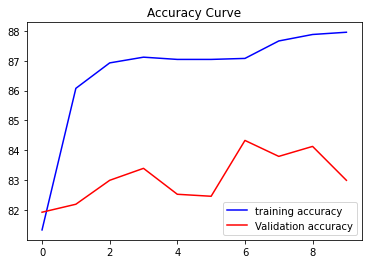

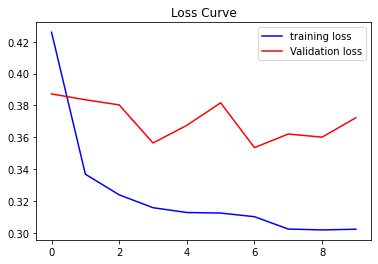

In [0]:
#accuracy curve
plt.subplots()
plt.plot(train_acc, 'b', label = 'training accuracy')
plt.plot(val_acc, 'r', label = 'Validation accuracy')
plt.title("Accuracy Curve")
plt.legend()
plt.show()

#loss curve
plt.subplots()
plt.plot(np.array(train_loss)/375, 'b', label = 'training loss')
plt.plot(np.array(val_loss)/47, 'r', label = 'Validation loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

# Training Accuracy, Confusion matrix

In [0]:
correct = 0
total = 0
m = np.zeros((2,2))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 12,000 training images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected     normal')
print( '     infected      ',m[0][0],'    ', m[0][1])
print( '     normal        ',m[1][0],'     ', m[1][1])

Accuracy of the network on the 12,000 training images: 87 %
Confusion Matrix: 
  true\predicted  infected     normal
     infected       3899.0      1020.0
     normal         456.0       6625.0


# Validation Accuracy, Confusion matrix

In [0]:
correct = 0
total = 0
m = np.zeros((2,2))
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 1500 validation images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected    normal')
print( '     infected      ',m[0][0],'    ', m[0][1])
print( '     normal        ',m[1][0],'     ', m[1][1])

Accuracy of the network on the 1500 validation images: 84 %
Confusion Matrix: 
  true\predicted  infected    normal
     infected       458.0      157.0
     normal         79.0       806.0


# Test Accuracy, Confusion matrix and F1 score

In [0]:
correct = 0
total = 0
m = np.zeros((2,2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected    normal')
print( '     infected      ',m[0][0],'    ', m[0][1])
print( '     normal        ',m[1][0],'     ', m[1][1])

Accuracy of the network on the 1500 test images: 90 %
Confusion Matrix: 
  true\predicted  infected    normal
     infected       515.0      100.0
     normal         37.0       848.0


In [0]:
precision = m[0][0] / (m[0][0] + m[1][0])
recall = m[0][0] / (m[0][0] + m[0][1])
F1 = 2 * precision * recall / (precision + recall)
print('Precision: {:.3f}'.format(precision) )
print('Recall:    {:.3f}'.format(recall))
print('F1 score:  {:.3f}'.format(F1))

Precision: 0.933
Recall:    0.837
F1 score:  0.883


# **Task 2**

# Load pre-trained VGG16 model and replace the FC layers

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
num_features = vgg16.classifier[0].in_features

fc = nn.Sequential(
            nn.Linear(num_features, 220), # roll_no = 12, neurons = 120 + 100
            nn.ReLU(True),
            nn.Linear(220, 2)
        )
vgg16.classifier = fc
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Train the VGG16 model on our dataset (No layers are frozen)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

val_loss = list()
val_acc = list()
train_loss = list()
train_acc = list()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        #compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Acc: {}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item(), 100 * correct / total))
    
    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    val_loss.append(running_loss)
    val_acc.append(100 * correct / total)

print('Finished Training')
torch.save(vgg16.state_dict(), F'/content/drive/My Drive/Colab Notebooks/Assignment 5/vgg16_entire.pth')

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.075060 Acc: 89.73333333333333: : 375it [08:36,  1.38s/it]
Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.340808 Acc: 93.09166666666667: : 375it [08:36,  1.38s/it]
Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.162573 Acc: 93.85833333333333: : 375it [08:30,  1.36s/it]
Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.180500 Acc: 94.2: : 375it [08:31,  1.36s/it]
Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.150290 Acc: 94.66666666666667: : 375it [08:31,  1.36s/it]
Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.105318 Acc: 94.98333333333333: : 375it [08:32,  1.37s/it]
Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.018235 Acc: 95.29166666666667: : 375it [08:27,  1.35s/it]
Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.115474 Acc: 95.6: : 375it [08:30,  1.36s/it]
Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.174108 Acc: 95.525: : 375it [08:38,  1.38s/it]
Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.122769 Acc: 95.875: : 375it [08:33,  1.37s/it]


Finished Training


# Plot Accuracy and Loss curves

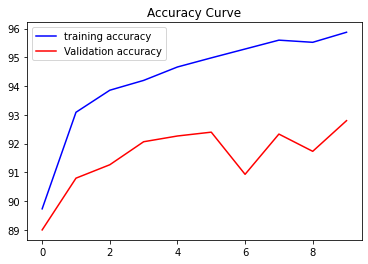

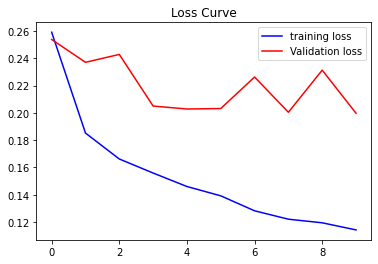

In [0]:
#accuracy curve
plt.subplots()
plt.plot(train_acc, 'b', label = 'training accuracy')
plt.plot(val_acc, 'r', label = 'Validation accuracy')
plt.title("Accuracy Curve")
plt.legend()
plt.show()

#loss curve
plt.subplots()
plt.plot(np.array(train_loss)/375, 'b', label = 'training loss')
plt.plot(np.array(val_loss)/47, 'r', label = 'Validation loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

# Training accuracy, Confusion matrix

In [0]:
correct = 0
total = 0
m = np.zeros((2,2))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 12,000 training images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected     normal')
print( '     infected      ',m[0][0],'    ', m[0][1])
print( '     normal        ',m[1][0],'     ', m[1][1])

Accuracy of the network on the 12,000 training images: 96 %
Confusion Matrix: 
  true\predicted  infected     normal
     infected       4609.0      310.0
     normal         114.0       6967.0


# Validation accuracy, Confusion matrix

In [0]:
correct = 0
total = 0
m = np.zeros((2,2))
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 1500 validation images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected     normal')
print( '     infected      ',m[0][0],'    ', m[0][1])
print( '     normal        ',m[1][0],'     ', m[1][1])

Accuracy of the network on the 1500 validation images: 92 %
Confusion Matrix: 
  true\predicted  infected     normal
     infected       544.0      71.0
     normal         37.0       848.0


# Testing accuracy, Confusion matrix and F1 score

In [0]:
correct = 0
total = 0
m = np.zeros((2,2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected    normal')
print( '     infected      ',m[0][0],'       ', m[0][1])
print( '     normal        ',m[1][0],'       ', m[1][1])

Accuracy of the network on the 1500 test images: 97 %
Confusion Matrix: 
  true\predicted  infected    normal
     infected       584.0         31.0
     normal         10.0         875.0


In [0]:
precision = m[0][0] / (m[0][0] + m[1][0])
recall = m[0][0] / (m[0][0] + m[0][1])
F1 = 2 * precision * recall / (precision + recall)
print('Precision: {:.3f}'.format(precision) )
print('Recall:    {:.3f}'.format(recall))
print('F1 score:  {:.3f}'.format(F1))

Precision: 0.983
Recall:    0.950
F1 score:  0.966


# Load pre-trained ResNet18 model and replace the FC layers

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)

num_features = resnet18.fc.in_features
my_fc = nn.Sequential(
            nn.Linear(num_features, 220), # roll_no = 12, neurons = 120 + 100
            nn.ReLU(True),
            nn.Linear(220, 2)
        )
resnet18.fc = my_fc
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

# Train the ResNet18 model on our dataset (No layers are frozen)

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

val_loss = list()
val_acc = list()
train_loss = list()
train_acc = list()

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        #compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} Acc: {:.3f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item(), 100 * correct / total))
    
    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    val_loss.append(running_loss)
    val_acc.append(100 * correct / total)

print('Finished Training')
torch.save(resnet18.state_dict(), F'/content/drive/My Drive/Colab Notebooks/Assignment 5/resnet18_entire.pth')

Train Epoch: 0 [11968/12000 (100%)]	Loss: 0.315197 Acc: 87.733: : 375it [05:49,  1.07it/s]
Train Epoch: 1 [11968/12000 (100%)]	Loss: 0.124405 Acc: 91.825: : 375it [05:40,  1.10it/s]
Train Epoch: 2 [11968/12000 (100%)]	Loss: 0.158920 Acc: 92.417: : 375it [05:49,  1.07it/s]
Train Epoch: 3 [11968/12000 (100%)]	Loss: 0.105553 Acc: 93.033: : 375it [05:45,  1.08it/s]
Train Epoch: 4 [11968/12000 (100%)]	Loss: 0.139084 Acc: 93.925: : 375it [05:40,  1.10it/s]
Train Epoch: 5 [11968/12000 (100%)]	Loss: 0.090538 Acc: 94.333: : 375it [05:38,  1.11it/s]
Train Epoch: 6 [11968/12000 (100%)]	Loss: 0.064761 Acc: 94.325: : 375it [05:43,  1.09it/s]
Train Epoch: 7 [11968/12000 (100%)]	Loss: 0.156568 Acc: 94.700: : 375it [05:40,  1.10it/s]
Train Epoch: 8 [11968/12000 (100%)]	Loss: 0.120472 Acc: 94.758: : 375it [05:39,  1.11it/s]
Train Epoch: 9 [11968/12000 (100%)]	Loss: 0.070045 Acc: 95.075: : 375it [05:39,  1.10it/s]


Finished Training


# Plot Accuracy and Loss curves

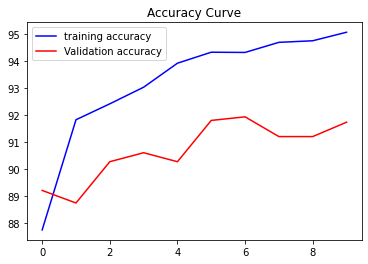

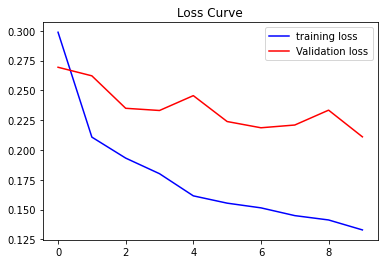

In [0]:
#accuracy curve
plt.subplots()
plt.plot(train_acc, 'b', label = 'training accuracy')
plt.plot(val_acc, 'r', label = 'Validation accuracy')
plt.title("Accuracy Curve")
plt.legend()
plt.show()

#loss curve
plt.subplots()
plt.plot(np.array(train_loss)/375, 'b', label = 'training loss')
plt.plot(np.array(val_loss)/47, 'r', label = 'Validation loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

# Training Accuracy, Confusion matrix

In [0]:
correct = 0
total = 0
m = np.zeros((2,2))
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 12,000 training images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected     normal')
print( '     infected      ',m[0][0],'    ', m[0][1])
print( '     normal        ',m[1][0],'     ', m[1][1])

Accuracy of the network on the 12,000 training images: 95 %
Confusion Matrix: 
  true\predicted  infected     normal
     infected       4624.0      295.0
     normal         236.0       6845.0


# Validation Accuracy, Confusion matrix

In [0]:
correct = 0
total = 0
m = np.zeros((2,2))
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 1500 validation images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected    normal')
print( '     infected      ',m[0][0],'    ', m[0][1])
print( '     normal        ',m[1][0],'     ', m[1][1])

Accuracy of the network on the 1500 validation images: 92 %
Confusion Matrix: 
  true\predicted  infected    normal
     infected       555.0      60.0
     normal         53.0       832.0


# Test Accuracy, Confusion matrix and F1 score

In [0]:
correct = 0
total = 0
m = np.zeros((2,2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        m += confusion_matrix (labels.to('cpu'), predicted.to('cpu'))

print('Accuracy of the network on the 1500 test images: %d %%' % (
    100 * correct / total))
print('Confusion Matrix: ')
print( '  true\predicted  infected    normal')
print( '     infected      ',m[0][0],'    ', m[0][1])
print( '     normal        ',m[1][0],'     ', m[1][1])

Accuracy of the network on the 1500 test images: 96 %
Confusion Matrix: 
  true\predicted  infected    normal
     infected       580.0      35.0
     normal         13.0       872.0


In [0]:
precision = m[0][0] / (m[0][0] + m[1][0])
recall = m[0][0] / (m[0][0] + m[0][1])
F1 = 2 * precision * recall / (precision + recall)
print('Precision: {:.3f}'.format(precision) )
print('Recall:    {:.3f}'.format(recall))
print('F1 score:  {:.3f}'.format(F1))

Precision: 0.978
Recall:    0.943
F1 score:  0.960
